In [35]:
### Objective:
'''
3.  Backtest an alternative Portfolio B with size of this allocation adjustable and using data going back to 1972. 
Initially, the alternative strategy should be the XAU trade model outlined below, with the potential to test other alternative strategies in the future. 
Record monthly performance of Portfolio B over the course of historical backtest and record the same overall performance metrics used for Portfolio A
Use ticker XAU Curncy and SPX Index. The trade trigger is XAU bull trend aligned simultaneously with SPX/XAU ratio bear trend. 
The trade triggers and exits can be optimized based on any combination of smoothed moving average crosses. 5,20,63,252 using daily data. 4,13,52 using weekly closing price data. 3 and 12 for monthly closing data.
'''

'\n3.  Backtest an alternative Portfolio B with size of this allocation adjustable and using data going back to 1972. \nInitially, the alternative strategy should be the XAU trade model outlined below, with the potential to test other alternative strategies in the future. \nRecord monthly performance of Portfolio B over the course of historical backtest and record the same overall performance metrics used for Portfolio A\nUse ticker XAU Curncy and SPX Index. The trade trigger is XAU bull trend aligned simultaneously with SPX/XAU ratio bear trend. \nThe trade triggers and exits can be optimized based on any combination of smoothed moving average crosses. 5,20,63,252 using daily data. 4,13,52 using weekly closing price data. 3 and 12 for monthly closing data.\n'

In [36]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import import_ipynb
from tqdm import tqdm
from Functions import calc_percent, calc_pnl
import numpy as np
import pandas as pd
import quantstats as qs 
import sys

In [37]:
long_terms = [i for i in range(10, 256, 5)]
short_terms = [i for i in range(5, 97, 5)]

In [38]:
# find all combinations of long_term and short_term
# drop if short_term >= long_term
combinations = [(long_term, short_term) for long_term in long_terms for short_term in short_terms if short_term < long_term]
print(f'combinations: {len(combinations)}')

combinations: 779


In [39]:
# Read in Data
data = pd.read_excel('equity_bond_gold.xlsx', na_values=['#N/A N/A'], sheet_name='equity_bond_gold_price')

# Rename the specified columns
data = data.rename(columns={
    'LUATTRUU Index': 'Bond',
    'SPXT Index': 'SP500_tr',
    'SPX Index': 'SP500',
    'XAU Curncy': 'Gold'
})

# Calculate the ratio of SP500 to Gold
data['SP500_Gold_Ratio'] = data['SP500'] / data['Gold']

data

,Dates,Bond,SP500_tr,SP500,Gold,SP500_Gold_Ratio
0,1973-02-01,98.99,NaN,114.76,65.14,1.761744
1,1973-02-02,98.99,NaN,114.35,65.14,1.755450
2,1973-02-05,98.99,NaN,114.23,65.14,1.753608
3,1973-02-06,98.99,NaN,114.45,65.14,1.756985
4,1973-02-07,98.99,NaN,113.66,65.14,1.744857
...,...,...,...,...,...,...
13497,2024-10-28,2307.48,12751.22,5823.52,2742.46,2.123466
13498,2024-10-29,2308.77,12771.80,5832.92,2774.74,2.102150
13499,2024-10-30,2307.28,12729.73,5813.67,2787.61,2.085539
13500,2024-10-31,2308.14,12493.74,5705.45,2743.97,2.079268


In [40]:
df = data[data['Dates'] >= '1994-03-01']
df.set_index('Dates', inplace=True)
df.head()

,Bond,SP500_tr,SP500,Gold,SP500_Gold_Ratio
Dates,,,,,
1994-03-01,684.43,568.33,464.44,378.75,1.226244
1994-03-02,684.56,569.00,464.81,378.10,1.229331
1994-03-03,682.84,566.83,463.01,377.85,1.225380
1994-03-04,682.36,569.00,464.74,377.20,1.232078
1994-03-07,684.15,571.72,466.91,376.40,1.240462


In [62]:
def calculate_max_drawdown(strategy_returns):
    """
    Calculates the maximum drawdown for a series of cumulative returns.
    
    Args:
        strategy_returns (Series): A series representing cumulative returns of a strategy.
        
    Returns:
        float: Maximum drawdown as a positive number.
    """
    cumulative_returns = (1 + strategy_returns).cumprod()
    rolling_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - rolling_max) / rolling_max
    max_drawdown = drawdown.min()  # Minimum of drawdown series represents the maximum drawdown
    return abs(max_drawdown)  # Return as positive


def calc_factor_and_gen_signal(price_series, long_term, short_term):
    """
    Calculates an exponential moving average factor and generates a buy/sell signal.
    
    Args:
        price_series (Series): A single column representing the price series.
        long_term (int): Long-term EMA period.
        short_term (int): Short-term EMA period.
        
    Returns:
        DataFrame: DataFrame with signals (1 for buy, 0 for sell).
    """
    df = pd.DataFrame(price_series)  # Convert to DataFrame to apply calculations
    df['long_ma'] = df[price_series.name].ewm(span=long_term, adjust=False).mean()  # Smoothed long-term EMA
    df['short_ma'] = df[price_series.name].ewm(span=short_term, adjust=False).mean()  # Smoothed short-term EMA
    
    # Generate buy/sell signal: 1 if short_ma > long_ma, 0 otherwise
    df['signal'] = np.where(df['short_ma'] > df['long_ma'], 1, 0)
    return df[['signal']]


def pnl_evaluation(price_series, signal_series):
    """
    Evaluates PnL based on signals and calculates both Sharpe ratio and max drawdown.
    
    Args:
        price_series (Series): The price series used to calculate returns.
        signal_series (Series): The column containing buy/sell signals.
        
    Returns:
        tuple: Sharpe ratio and max drawdown.
    """
    df = pd.DataFrame({
        'price': price_series,
        'signal': signal_series
    })
    
    # Calculate daily returns and apply signals
    df['daily_return'] = df['price'].pct_change().fillna(0)
    df['strategy_return'] = df['signal'].shift(1) * df['daily_return']  # Shift signal to avoid lookahead bias
    
    # Calculate Sharpe Ratio
    sharpe_ratio = df['strategy_return'].mean() / df['strategy_return'].std() * np.sqrt(252)
    
    # Calculate Maximum Drawdown
    max_drawdown = calculate_max_drawdown(df['strategy_return'])
    
    return sharpe_ratio, max_drawdown

In [52]:
results = []

# Run each combination and calculate Sharpe ratio and maximum drawdown
for long_term, short_term in tqdm(combinations, desc="Processing combinations"):
    # Calculate signals based on moving averages using the SP500 to Gold 
    signal_df = calc_factor_and_gen_signal(df['SP500_Gold_Ratio'], long_term, short_term)
    
    # Evaluate PnL and calculate both Sharpe ratio and maximum drawdown of Gold but when it is triggered by the ratio above
    sharpe_ratio, max_drawdown = pnl_evaluation(df['Gold'], signal_df['signal'])
    
    # Store results
    results.append((long_term, short_term, sharpe_ratio, max_drawdown))

# Convert results to DataFrame
result_df = pd.DataFrame(results, columns=['long_term', 'short_term', 'sharpe_ratio', 'max_drawdown'])

Processing combinations: 100%|██████████| 779/779 [00:03<00:00, 228.85it/s]


In [63]:
# Create pivot table for Sharpe Ratio
Sharpe_Ratio = result_df.pivot_table(index='short_term', columns='long_term', values='sharpe_ratio').values

# Define sorted lists of long and short terms for axes
long_terms = sorted(result_df['long_term'].unique())
short_terms = sorted(result_df['short_term'].unique())

# Create 3D surface plot for Sharpe Ratio heatmap
fig = go.Figure(data=[go.Surface(z=Sharpe_Ratio, x=long_terms, y=short_terms, colorscale='Viridis')])

fig.update_layout(
    title='Sharpe Ratio 3D Heatmap',
    scene=dict(
        xaxis_title='Long Term',
        yaxis_title='Short Term',
        zaxis_title='Sharpe Ratio'
    ),
    autosize=True
)

fig.write_html('sharpe_ratio_3d_heatmap.html')
fig.show()


In [54]:
# Create pivot table for maximum drawdown
Max_Drawdown = result_df.pivot_table(index='short_term', columns='long_term', values='max_drawdown').values

# Define sorted lists of long and short terms for axes
long_terms = sorted(result_df['long_term'].unique())
short_terms = sorted(result_df['short_term'].unique())

# Create 3D surface plot for Maximum Drawdown heatmap
fig = go.Figure(data=[go.Surface(z=Max_Drawdown, x=long_terms, y=short_terms, colorscale='Viridis')])

fig.update_layout(
    title='Maximum Drawdown 3D Heatmap',
    scene=dict(
        xaxis_title='Long Term',
        yaxis_title='Short Term',
        zaxis_title='Max Drawdown'
    ),
    autosize=True
)

fig.write_html('max_drawdown_3d_heatmap.html')
fig.show()


In [55]:
# Rank by Sharpe ratio (higher is better) and maximum drawdown (lower is better)
result_df['sharpe_rank'] = result_df['sharpe_ratio'].rank(ascending=False)
result_df['drawdown_rank'] = result_df['max_drawdown'].rank(ascending=True)


In [66]:
# Calculate combined rank score
result_df['combined_rank'] = result_df['sharpe_rank'] + result_df['drawdown_rank']
result_df.sort_values('drawdown_rank')

,long_term,short_term,sharpe_ratio,max_drawdown,sharpe_rank,drawdown_rank,combined_rank
7,25,10,0.313594,0.360589,199.0,1.0,200.0
5,20,15,0.289177,0.360814,343.0,2.0,345.0
29,45,10,0.406260,0.362505,4.0,3.0,7.0
21,40,5,0.356476,0.366719,81.0,4.0,85.0
336,140,70,0.301375,0.373781,260.0,5.0,265.0
...,...,...,...,...,...,...,...
682,230,90,0.066153,0.481975,777.0,775.0,1552.0
700,235,85,0.069236,0.483957,776.0,776.0,1552.0
778,255,95,0.095560,0.487356,755.0,777.0,1532.0
664,225,95,0.060951,0.496999,778.0,778.0,1556.0


In [ ]:
# Sort by combined rank and select the top strategy
best_strategy = result_df.sort_values('combined_rank').iloc[0]

In [58]:
# Display the best strategy parameters along with its ranks
print("Best Strategy Parameters:")
print(f"Long Term: {best_strategy['long_term']}")
print(f"Short Term: {best_strategy['short_term']}")
print(f"Sharpe Ratio: {best_strategy['sharpe_ratio']}")
print(f"Max Drawdown: {best_strategy['max_drawdown']}")
print(f"Sharpe Ratio Rank: {int(best_strategy['sharpe_rank'])}")
print(f"Max Drawdown Rank: {int(best_strategy['drawdown_rank'])}")

Best Strategy Parameters:
Long Term: 45.0
Short Term: 10.0
Sharpe Ratio: 0.4062600407131421
Max Drawdown: 0.36250487179630997
Sharpe Ratio Rank: 4
Max Drawdown Rank: 3


C:\Users\neoel\AppData\Local\Temp\ipykernel_1660\1681328934.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Trigger Points:
            signal  trigger
Dates                      
1994-03-02       1        1
1994-03-11      -1       -1
1994-08-30       1        1
1994-09-26      -1       -1
1994-11-08       1        1
1994-11-24      -1       -1
1994-12-23       1        1
1998-10-08      -1       -1
1998-11-04       1        1
1999-10-14      -1       -1
1999-12-13       1        1
2000-02-21      -1       -1
2000-03-22       1        1
2000-11-30      -1       -1
2003-06-24       1        1
2003-11-20      -1       -1
2004-01-28       1        1
2004-08-16      -1       -1
2005-01-19       1        1
2005-04-21      -1       -1
2005-05-23       1        1
2005-09-20      -1       -1
2006-10-10       1        1
2007-02-28      -1       -1
2007-05-21       1        1
2007-08-30      -1       -1
2009-08-24       1        1
2009-11-10      -1       -1
2010-03-18       1        1
2010-05-14      -1       -1
2011-01-24       1        1
2011-04-21      -1       -1
2012-02-10       1        1
2012

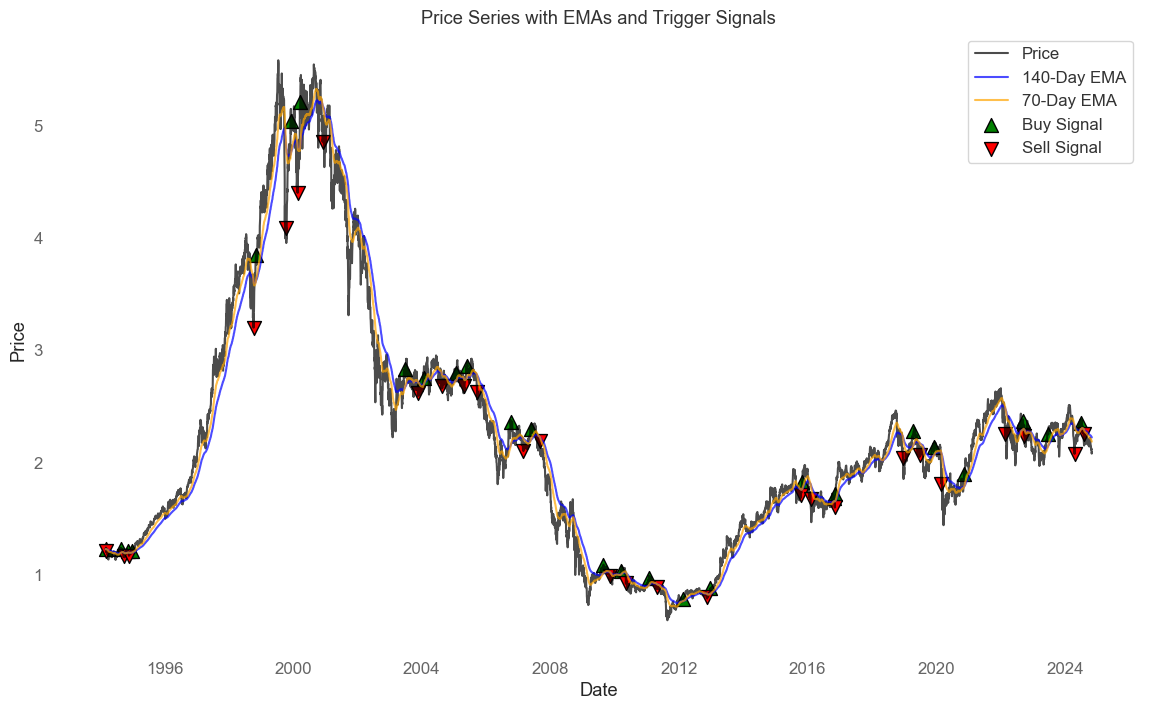

In [67]:
# Assume df['Gold'] is the series you're analyzing
price_series = df['SP500_Gold_Ratio']  # Replace 'Gold' with the actual column

# Set optimal long and short terms
long_term = 140
short_term = 70

# Calculate smoothed (EMA) moving averages with .loc[]
df.loc[:, 'long_ma'] = price_series.ewm(span=long_term, adjust=False).mean()
df.loc[:, 'short_ma'] = price_series.ewm(span=short_term, adjust=False).mean()

# Generate signals based on the EMA crossover with .loc[]
df.loc[:, 'signal'] = np.where(df['short_ma'] > df['long_ma'], 1, -1)


# Initialize the trigger column with zeros
df['trigger'] = 0

# Identify buy triggers (signal changes from -1 to 1)
df.loc[(df['signal'] == 1) & (df['signal'].shift(1) == -1), 'trigger'] = 1

# Identify sell triggers (signal changes from 1 to -1)
df.loc[(df['signal'] == -1) & (df['signal'].shift(1) == 1), 'trigger'] = -1

buy_signals = df[df['trigger'] == 1]
sell_signals = df[df['trigger'] == -1]

# Print rows with crossover points to verify
trigger_points = df[df['trigger'] == 1]

print("Trigger Points:")
print(df[['signal', 'trigger']][df['trigger'] != 0])

# Plotting
plt.figure(figsize=(14, 8))
plt.plot(price_series.index, price_series, label='Price', color='black', alpha=0.7)
plt.plot(price_series.index, df['long_ma'], label=f'{long_term}-Day EMA', color='blue', alpha=0.7)
plt.plot(price_series.index, df['short_ma'], label=f'{short_term}-Day EMA', color='orange', alpha=0.7)

# Add buy signals (green upward triangles)
plt.scatter(buy_signals.index, price_series[buy_signals.index],
            marker='^', color='green', label='Buy Signal', s=100, edgecolor='black')

# Add sell signals (red downward triangles)
plt.scatter(sell_signals.index, price_series[sell_signals.index],
            marker='v', color='red', label='Sell Signal', s=100, edgecolor='black')

# Label and show plot
plt.title('Price Series with EMAs and Trigger Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()


In [68]:
# Display rows where a trigger (crossover) occurs
trigger_points = df[df['trigger'] == 1]

# Print trigger points to inspect
print("Trigger points (crossovers):")
print(trigger_points[['long_ma', 'short_ma', 'signal', 'trigger']])


Trigger points (crossovers):
             long_ma  short_ma  signal  trigger
Dates                                          
1994-03-02  1.226288  1.226331       1        1
1994-08-30  1.196870  1.197194       1        1
1994-11-08  1.195443  1.195605       1        1
1994-12-23  1.195253  1.195384       1        1
1998-11-04  3.616864  3.618737       1        1
1999-12-13  4.777381  4.779184       1        1
2000-03-22  4.823695  4.827787       1        1
2003-06-24  2.668708  2.669190       1        1
2004-01-28  2.703223  2.703505       1        1
2005-01-19  2.731894  2.732174       1        1
2005-05-23  2.748481  2.749450       1        1
2006-10-10  2.160021  2.162522       1        1
2007-05-21  2.194471  2.195143       1        1
2009-08-24  1.009570  1.010276       1        1
2010-03-18  1.003555  1.003946       1        1
2011-01-24  0.904451  0.904909       1        1
2012-02-10  0.761430  0.761435       1        1
2012-12-20  0.827414  0.827758       1        1
2015-10-29 

In [69]:
# Ensure the DataFrame index is datetime
df.index = pd.to_datetime(df.index)

# Initialize lists to store trade entry and exit dates
trade_entries = []
trade_exits = []

# Variable to track if a trade is open
in_trade = False

# Iterate over the DataFrame rows
for date, row in df.iterrows():
    trigger = row['trigger']
    if trigger == 1 and not in_trade:
        # Buy signal - start of a trade
        trade_entries.append(date)
        in_trade = True
    elif trigger == -1 and in_trade:
        # Sell signal - end of a trade
        trade_exits.append(date)
        in_trade = False

# Handle case where the last trade hasn't been closed yet
if in_trade:
    # Close the trade at the last available date
    trade_exits.append(df.index[-1])

# Ensure entries and exits are paired
if len(trade_entries) != len(trade_exits):
    raise ValueError("Mismatch between number of trade entries and exits.")

# Create a DataFrame to store trades
trades = pd.DataFrame({
    'Entry Date': trade_entries,
    'Exit Date': trade_exits
})

# Calculate the duration of each trade
trades['Duration'] = (trades['Exit Date'] - trades['Entry Date']).dt.days

# Calculate the number of buys and sells
number_of_buys = len(trades)
number_of_sells = len(trades)

# Calculate the average duration of trades
average_duration = trades['Duration'].mean()

# Output the results
print(f"Number of buys: {number_of_buys}")
print(f"Number of sells: {number_of_sells}")
print(f"Average trade duration: {average_duration:.2f} days")

# Display the trades DataFrame
print("\nTrade Details:")
print(trades)


Number of buys: 27
Number of sells: 27
Average trade duration: 232.26 days

Trade Details:
   Entry Date  Exit Date  Duration
0  1994-03-02 1994-03-11         9
1  1994-08-30 1994-09-26        27
2  1994-11-08 1994-11-24        16
3  1994-12-23 1998-10-08      1385
4  1998-11-04 1999-10-14       344
5  1999-12-13 2000-02-21        70
6  2000-03-22 2000-11-30       253
7  2003-06-24 2003-11-20       149
8  2004-01-28 2004-08-16       201
9  2005-01-19 2005-04-21        92
10 2005-05-23 2005-09-20       120
11 2006-10-10 2007-02-28       141
12 2007-05-21 2007-08-30       101
13 2009-08-24 2009-11-10        78
14 2010-03-18 2010-05-14        57
15 2011-01-24 2011-04-21        87
16 2012-02-10 2012-11-12       276
17 2012-12-20 2015-10-15      1029
18 2015-10-29 2016-02-03        97
19 2016-10-25 2016-11-03         9
20 2016-11-10 2018-12-18       768
21 2019-04-16 2019-06-26        71
22 2019-12-10 2020-02-27        79
23 2020-11-13 2022-02-24       468
24 2022-09-09 2022-09-28        19